# SYS 611: SimPy Queuing System (Object-oriented)

Paul T. Grogan <pgrogan@stevens.edu>

This example creates a queuing system simulation in SimPy using object-oriented concepts.

## Dependencies

This example is compatible with Python 2 environments through use of the `__future__` library function. Additionally, this example uses the `numpy`, `matplotlib.pyplot` and `simpy` libraries. SimPy is not a standard library included in most Python distributions. The `!pip install simpy` command below attempts to install it using the pip package management system.

In [1]:
# import the python3 behavior for importing, division, and printing in python2
from __future__ import absolute_import, division, print_function

# import the numpy package and refer to it as `np`
import numpy as np

# import the matplotlib pyplot package and refer to it as `plt`
import matplotlib.pyplot as plt

!pip install simpy

# import the simpy package
import simpy

## Simulation Model

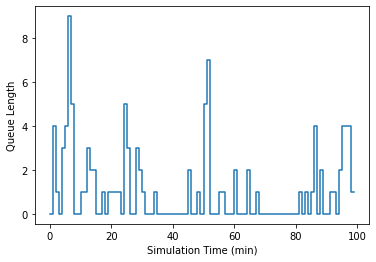

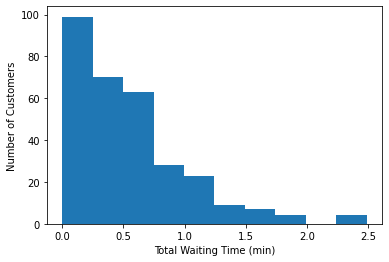

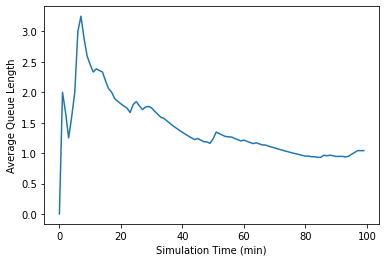

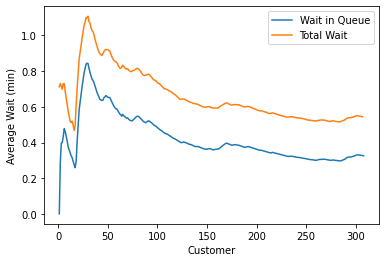

In [2]:
class CafeJava(object):
    def __init__(self, env, num_servers, _lambda, _mu):
        self.env = env
        self.servers = simpy.Resource(env, num_servers)
        self._mu = _mu
        self._lambda = _lambda
        self.wait_queue = []
        self.wait_total = []
        
    def run(self):
        while True:
            # wait for the next arrival
            yield self.env.timeout(np.random.exponential(1/self._lambda))
            # launch the customer process
            self.env.process(self.handle_customer())

    def handle_customer(self):
        with self.servers.request() as request:
            arrival_time = self.env.now
            # wait to get a server
            yield request
            service_time = self.env.now
            self.wait_queue.append(service_time - arrival_time)
            # wait for the service to complete
            yield self.env.timeout(np.random.exponential(1/self._mu))
            depart_time = self.env.now
            self.wait_total.append(depart_time - arrival_time)

def observe(env, cafe, obs_time, obs_length_queue):
    while True:
        # record the observation time and queue length
        obs_time.append(env.now)
        obs_length_queue.append(len(cafe.servers.queue))
        # wait for the next minute
        yield env.timeout(1.0)
        
# create the simulation environment
env = simpy.Environment()

# create arrays to record data
obs_time = []
obs_length_queue = []

# create the cafe
cafe = CafeJava(env, 1, 3.0, 4.0)

# add the cafe process
env.process(cafe.run())
# add the observation process
env.process(observe(env, cafe, obs_time, obs_length_queue))
# run the simulation for 100 minutes
env.run(until=100)

# create a plot showing the queue length at each time
plt.figure()
plt.step(obs_time, obs_length_queue, where='post')
plt.xlabel('Simulation Time (min)')
plt.ylabel('Queue Length')
plt.show()

# create a plot showing the histogram of waiting time
plt.figure()
plt.hist(cafe.wait_total)
plt.xlabel('Total Waiting Time (min)')
plt.ylabel('Number of Customers')
plt.show()

# create a plot showing the average queue length at each time
plt.figure()
plt.plot(obs_time, np.cumsum(obs_length_queue)/np.arange(1, 1+len(obs_length_queue)))
plt.xlabel('Simulation Time (min)')
plt.ylabel('Average Queue Length')
plt.show()

# create a plot showing the average wait time (queue and total) at each time
plt.figure()
plt.plot(1+np.arange(len(cafe.wait_queue)), np.cumsum(cafe.wait_queue)/np.arange(1, 1+len(cafe.wait_queue)), label='Wait in Queue')
plt.plot(1+np.arange(len(cafe.wait_total)), np.cumsum(cafe.wait_total)/np.arange(1, 1+len(cafe.wait_total)), label='Total Wait')
plt.xlabel('Customer')
plt.ylabel('Average Wait (min)')
plt.legend()
plt.show()

## Monte Carlo Simulation

In [3]:
NUM_RUNS = 10

# array to store outputs
AVERAGE_WAIT = []

for i in range(NUM_RUNS):
    # set the initial seed
    np.random.seed(i)

    # create the simulation environment
    env = simpy.Environment()

    # create arrays to record data
    obs_time = []
    obs_length_queue = []

    # create the cafe
    cafe = CafeJava(env, 1, 3.0, 4.0)

    # add the cafe process
    env.process(cafe.run())
    # add the observation process
    env.process(observe(env, cafe, obs_time, obs_length_queue))
    # run the simulation
    env.run(until=100)
    
    # record the final average waiting time
    AVERAGE_WAIT.append(np.mean(cafe.wait_total))

# print final results to console
print('Average waiting time for N={:} runs:'.format(NUM_RUNS))
print('\n'.join('{:.2f}'.format(i) for i in AVERAGE_WAIT))

# write results to CSV file
import csv

with open('queuing.csv', 'w') as output:
    writer = csv.writer(output)
    writer.writerow(['Run', 'Avg. Total Waiting Time'])
    for i, sample in enumerate(AVERAGE_WAIT):
        writer.writerow([i+1, sample])

Average waiting time for N=10 runs:
0.98
0.60
1.65
0.68
0.74
0.76
1.06
0.92
3.11
1.12
